In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from matplotlib.patches import Ellipse

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#让jupyter输出矢量图
%config InlineBackend.figure_format = "svg"

In [2]:
def xgene(Nt):
    X = np.zeros((Nt,1))
    
    d = np.random.laplace(loc=0.0, scale=20, size=(Nt-1,1))
    X[0] = np.random.normal(0,1)
    for i in range(1,Nt):
        X[i] = X[i-1] + d[i-1]
    return X

$Y=Ax+w$

In [3]:
def initxHy(Nr,Nt,mu_x,sig_x,wvar,s):
    
    X = xgene(Nt)
        
    H = np.random.normal(0,1/math.sqrt(Nr),size=(Nr,Nt))
    W = np.random.normal(0,math.sqrt(wvar),size=(Nr,1))
    Y = np.matmul(H,X) + W
    return X,H,Y

In [4]:

def damping(old,new,dampFac):
    out = dampFac*old+(1-dampFac)*new
    return out

def N(x, mean, sigma):
    return np.exp(-1*(np.abs(x-mean)**2)/(2*sigma)) / ((2*np.pi*sigma)**0.5) 

def d(Q):
    return np.diag(Q).reshape((Q.shape[0],1))

def diag(X):
    return np.eye(len(X))*X
#
def bound1(V_ab,X_ab,V_old,X_old):
    num_old = V_ab <= 0
    num_new = V_ab > 0
    V_a = V_old * num_old + V_ab * num_new
    X_a = X_old * num_old + X_ab * num_new
    return V_a,X_a 

def bound(X,eps1):
    XB = np.zeros(X.shape)
    temp = X <=eps1
    XB[temp] = eps1
    XB[~temp] = X[~temp]
    return XB

In [5]:
def estimateZ(m1_p,v1_p,Y):
    # print(v1_p)
    
    mean = Y.copy() 
    gamw = np.eye(len(Y))*1/wvar
    gam1 = diag(1/v1_p)
    Qz = np.linalg.inv(gamw + gam1)
    Vz = d(Qz)    
    z_hat = np.matmul(Qz,np.matmul(gamw,mean)+np.matmul(gam1,m1_p))
    return z_hat,Vz

In [6]:
def hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s,mode = 'lim'):
    MSE = np.zeros((k_max,T))
    Mse = np.zeros((k_max))
    for b in range(0,T):
        X,H,Y = initxHy(Nr,Nt,mu_x,sig_x,wvar,s)
        Ht = H.T
        #迭代初始系数，其中_p为正向消息，_m为负向消息
        #ma[0]、va[0]、mb[Nt-1]、vb[Nt-1]无意义
        m1_p = np.zeros((Nr,1))
        v1_p = np.ones((Nr,1))
        m1_m = np.zeros((Nr,1))
        v1_m = np.ones((Nr,1))
        ma_p = np.zeros((Nt,1))
        va_p =np.ones((Nt,1))
        ma_m = np.zeros((Nt,1))
        va_m =np.ones((Nt,1))
        mb_p = np.zeros((Nt,1))
        vb_p = np.ones((Nt,1))
        mb_m = np.zeros((Nt,1))
        vb_m = np.ones((Nt,1))
        mc_p = np.zeros((Nt,1))
        vc_p = np.ones((Nt,1))
        mc_m = np.zeros((Nt,1))
        vc_m = np.ones((Nt,1))
        
        ma_p_new = np.zeros((Nt,1))
        va_p_new =np.ones((Nt,1))
        mb_p_new = np.zeros((Nt,1))
        vb_p_new =np.ones((Nt,1))
        for t in range(0,k_max):
            z_hat,Vz = estimateZ(m1_p,v1_p,Y)
            #print(Vz.T)
            if mode == 'lim':
                Vz = bound(Vz,eps)
            
            v1_m_new = 1/(1/Vz - 1/v1_p)
            m1_m_new = v1_m_new * (z_hat/Vz - m1_p/v1_p)#
            v1_m = damping(v1_m,v1_m_new,dampFac)
            m1_m = damping(m1_m,m1_m_new,dampFac)
            
            Qx_m1 = np.matmul(np.matmul(Ht,diag(1/v1_m)),H) + diag(1/vc_p)
            Qx_m = np.linalg.inv(Qx_m1)
            x_m = np.matmul(Qx_m,np.matmul(np.matmul(Ht,diag(1/v1_m)),m1_p) + mc_p/vc_p)
            Vx_m = d(Qx_m)
            if mode == 'lim':
                Vx_m = bound(Vx_m,eps)
            
            vc_m_new = 1/(1/Vx_m - 1/vc_p)
            mc_m_new = vc_m_new * (x_m/Vx_m - mc_p/vc_p)
            vc_m = damping(vc_m,vc_m_new,dampFac)
            mc_m = damping(mc_m,mc_m_new,dampFac)
            if mode == 'lim':
                vc_m = bound(vc_m,eps)
            
            va_m_new = 1/(1/vb_p + 1/vc_m)
            ma_m_new = va_m_new * (mb_p/vb_p + mc_m/vc_m)
            va_m_new[Nt-1] = vc_m[Nt-1]
            ma_m_new[Nt-1] = mc_m[Nt-1]
            va_m = damping(va_m,va_m_new,dampFac)
            ma_m = damping(ma_m,ma_m_new,dampFac)
            if mode == 'lim':
                va_m = bound(va_m,eps)
            
            vb_m_new =1/(1/va_p + 1/vc_m)
            mb_m_new =vb_m_new * (ma_p/va_p + mc_m/vc_m)
            vb_m_new[0] = vc_m[0]
            mb_m_new[0] = mc_m[0]
            vb_m = damping(vb_m,vb_m_new,dampFac)
            mb_m = damping(mb_m,mb_m_new,dampFac)
            if mode == 'lim':
                vb_m = bound(vb_m,eps)
            
            #计算ma+,va+
            for j in range(1,Nt):
                ma_p_new[j] = mb_m[j-1]
                va_p_new[j] = 2/(lamb**2) + vb_m[j-1]
                
            va_p = damping(va_p,va_p_new,dampFac)
            ma_p = damping(ma_p,ma_p_new,dampFac)
            if mode == 'lim':
                va_p = bound(va_p,eps)
            #print("第",t,"次迭代va_p",va_p)
            #print("第",t,"次迭代ma_p",ma_p)
            
            #计算mb+,vb+
            for j in range(0,Nt-1):
                mb_p_new[j] = ma_m[j+1]
                vb_p_new[j] = 2/(lamb**2) + va_m[j+1]
                
            vb_p = damping(vb_p,vb_p_new,dampFac)
            mb_p = damping(mb_p,mb_p_new,dampFac)
            if mode == 'lim':
                vb_p = bound(vb_p,eps)
            #print("第",t,"次迭代vb_p",vb_p)
            #print("第",t,"次迭代mb_p",mb_p)
            
            vc_p_new = 1/(1/vb_p +1/va_p)
            mc_p_new = vc_p_new*(mb_p/vb_p + ma_p/va_p)
            vc_p_new[0] = vb_p[0]
            mc_p_new[0] = mb_p[0]
            mc_p_new[Nt-1] = ma_p[Nt-1]
            vc_p_new[Nt-1] = va_p[Nt-1]
            vc_p = damping(vc_p,vc_p_new,dampFac)
            mc_p = damping(mc_p,mc_p_new,dampFac)
            if mode == 'lim':
                vc_p = bound(vc_p,eps)

            Vx_hat = 1/(1/vc_m + 1/vc_p)
            x_hat = Vx_hat * (mc_m/vc_m + mc_p/vc_p)
            
            Qx_p1 = np.matmul(np.matmul(Ht,diag(1/v1_m)),H) + diag(1/vc_p)
            Qx_p = np.linalg.inv(Qx_p1)
            mx_p = np.matmul(Qx_p,np.matmul(np.matmul(Ht,diag(1/v1_m)),m1_m) + mc_p/vc_p)
            z_hat_p = np.matmul(H,mx_p)
            Vz_p = d(np.matmul(np.matmul(H,Qx_p),Ht))
            
            #print("第",t,"次迭代Vz_p",Vz_p)
            if mode == 'lim':
                Vz_p = bound(Vz_p,eps)
            
            v1_p_new = 1/(1/Vz_p -1/v1_m)
            m1_p_new = v1_p_new*(z_hat_p/Vz_p -m1_m/v1_m)
            v1_p = damping(v1_p,v1_p_new,dampFac)
            m1_p = damping(m1_p,m1_p_new,dampFac)
            if mode == 'lim':
                v1_p = bound(v1_p,eps)
            MSE[t,b] = (1/Nt)*(sum((X-x_hat)**2))
            
    Mse = np.sum(MSE,1)/T
    return Mse,x_hat,Vx_hat

In [7]:
#se
def lam(Nr,Nt):
    
    H = np.random.normal(0,1/math.sqrt(Nr),size=(Nr,Nt))
    Ht = H.T
    A = np.matmul(Ht,H)
    
    lamA = np.linalg.eigvals(A)
    return lamA

def hybride_SE(Nr,Nt,k_max,wvar,lamb):
    semse = np.zeros(k_max) 
    lamA = lam(Nr,Nt)
    v1_p = 1
    va_p = 1
    vb_p = 1
    vc_p = 1
    Vz = 1
    v1_m = 1
    vc_m = 1
    for t in range(0,k_max):

        Vz_new = 1/(1/v1_p + 1/wvar)
        Vz = damping(Vz,Vz_new,0.01)
        
        v1_m_new = 1/(1/Vz - 1/v1_p)
        v1_m = damping(v1_m,v1_m_new,0.1)
        
        Vx_m = np.sum(1/(lamA/v1_m + 1/vc_p))/Nt
        vc_m = 1/(1/Vx_m - 1/vc_p)
        va_m = 1/(1/vb_p + 1/vc_m)
        vb_m = 1/(1/va_p + 1/vc_m)
        va_p = vb_m + 2/(lamb**2)
        vb_p = va_m + 2/(lamb**2)
        vc_p = 1/(1/va_p + 1/vb_p)
        semse[t] = 1/(1/vc_p + 1/vc_m)
        
        Vz_p = np.sum(lamA/(lamA/v1_m+1/vc_p))/Nr
        v1_p = 1/(1/Vz_p - 1/v1_m)
        
    #print(semse)
    return 10*np.log10(semse)
    #return semse

In [8]:
#M step
def calambda(Nt,x_hat):
    xi = np.zeros((Nt-1,1))
    xim1 = np.zeros((Nt-1,1))
    xi = x_hat[1:Nt]
    xim1 = x_hat[0:Nt-1]
    lamb = Nt/sum(np.absolute(xi-xim1))
    return lamb

In [9]:
#M step
def sumint(Vy,My,Vz,Mz,Nt):

    inte = np.zeros((Nt-1,1))
    for i in range(0,Nt-1):
        my = My[i]
        vy = Vy[i]
        mz = Mz[i]
        vz = Vz[i]
        f1 = lambda y,z:(y-z)*N(y,my,vy)*N(z,mz,vz)
        f2 = lambda y,z:(z-y)*N(y,my,vy)*N(z,mz,vz)

        g1 = lambda z:z
        
        inte[i] = scipy.integrate.dblquad(f1, -np.inf, np.inf, g1, np.inf)[0]+scipy.integrate.dblquad(f2, -np.inf, np.inf, -np.inf,g1)[0]
        
        print(inte[i])
    print("sum over")
    return sum(inte)
    
def calambda1(Nt,x_hat,Vx_hat):
    xi = np.zeros((Nt-1,1))
    xim1 = np.zeros((Nt-1,1))
    xi = x_hat[1:Nt]
    vi = Vx_hat[1:Nt]
    xim1 = x_hat[0:Nt-1]
    vim1 = Vx_hat[0:Nt-1]
    lamb = Nt/sumint(vi,xi,vim1,xim1,Nt)

    return lamb

def calambda2(Nt,x_hat,Vx_hat):
    xi = np.zeros((Nt-1,1))
    xim1 = np.zeros((Nt-1,1))
    xi = x_hat[1:Nt]
    vi = Vx_hat[1:Nt]
    xim1 = x_hat[0:Nt-1]
    vim1 = Vx_hat[0:Nt-1]
    lamb = Nt/sum(xi - xim1)
    return lamb

In [12]:
def hybrid_EM(Nr,Nt,wvar,k_max,Ti,lamb,dampFac,s,mode = 'lim'):
    MSE = np.zeros((k_max))
    Mse = np.zeros((k_max,Ti))
    X,H,Y = initxHy(Nr,Nt,mu_x,sig_x,wvar,s)
    Ht = H.T
    #迭代初始系数，其中_p为正向消息，_m为负向消息
    #ma[0]、va[0]、mb[Nt-1]、vb[Nt-1]无意义
    #初始化
    m1_p = np.zeros((Nr,1))
    v1_p = np.ones((Nr,1))
    m1_m = np.zeros((Nr,1))
    v1_m = np.ones((Nr,1))
    ma_p = np.zeros((Nt,1))
    va_p =np.ones((Nt,1))
    ma_m = np.zeros((Nt,1))
    va_m =np.ones((Nt,1))
    mb_p = np.zeros((Nt,1))
    vb_p = np.ones((Nt,1))
    mb_m = np.zeros((Nt,1))
    vb_m = np.ones((Nt,1))
    mc_p = np.zeros((Nt,1))
    vc_p = np.ones((Nt,1))
    mc_m = np.zeros((Nt,1))
    vc_m = np.ones((Nt,1))

    ma_p_new = np.zeros((Nt,1))
    va_p_new =np.ones((Nt,1))
    mb_p_new = np.zeros((Nt,1))
    vb_p_new =np.ones((Nt,1))
    #用一个class储存以上数据
    empa = EMPA(m1_p,v1_p,m1_m,v1_m, ma_p,va_p,ma_m,va_m, mb_p,vb_p,mb_m,vb_m, mc_p,vc_p,mc_m,vc_m, ma_p_new,va_p_new,mb_p_new,vb_p_new)
    empa.m1_p = m1_p
    empa.v1_p = v1_p
    empa.m1_m = m1_m
    empa.v1_m = v1_m
    empa.ma_p = ma_p
    empa.va_p = va_p
    empa.ma_m = ma_m
    empa.va_m = va_m
    empa.mb_p = mb_p
    empa.vb_p = vb_p
    empa.mb_m = mb_m
    empa.vb_m = vb_m
    empa.mc_p = mc_p
    empa.vc_p = vc_p
    empa.mc_m = mc_m
    empa.vc_m = vc_m
    empa.ma_p_new = ma_p_new
    empa.va_p_new = va_p_new
    empa.mb_p_new = mb_p_new
    empa.vb_p_new = vb_p_new
    
    #print(empa.vc_p)
    lambs = np.zeros((Ti,1))
    for i in range(0,Ti):
        #E_step
        MSE,x_hat,Vx_hat,empa = E_step_hy(empa,Nr,Nt,wvar,k_max,Ti,lamb,dampFac,s,X,Y,H,Ht,mode = 'lim')
        #储存MSE
        Mse[:,i] = MSE[:] 
        #M_step
        lamb = calambda(Nt,x_hat)
        #储存lamb
        lambs[i] = lamb
    return Mse,lambs

In [13]:
def E_step_hy(empa,Nr,Nt,wvar,k_max,Ti,lamb,dampFac,s,X,Y,H,Ht,mode = 'lim'):
    #数据读取
    m1_p = empa.m1_p
    v1_p = empa.v1_p
    m1_m = empa.m1_m
    v1_m = empa.v1_m
    ma_p = empa.ma_p
    va_p = empa.va_p
    ma_m = empa.ma_m
    va_m = empa.va_m
    mb_p = empa.mb_p
    vb_p = empa.vb_p
    mb_m = empa.mb_m
    vb_m = empa.vb_m
    mc_p = empa.mc_p
    vc_p = empa.vc_p
    mc_m = empa.mc_m
    vc_m = empa.vc_m
    ma_p_new = empa.ma_p_new
    va_p_new = empa.va_p_new
    mb_p_new = empa.mb_p_new
    vb_p_new = empa.vb_p_new
    
    MSE = np.zeros((k_max))
    for t in range(0,k_max): 
        # print(v1_p)
        z_hat,Vz = estimateZ(m1_p,v1_p,Y)
        #print(Vz.T)
        if mode == 'lim':
            Vz = bound(Vz,eps)

        v1_m_new = 1/(1/Vz - 1/v1_p)
        m1_m_new = v1_m_new * (z_hat/Vz - m1_p/v1_p)#
        v1_m = damping(v1_m,v1_m_new,dampFac)
        m1_m = damping(m1_m,m1_m_new,dampFac)

        Qx_m1 = np.matmul(np.matmul(Ht,diag(1/v1_m)),H) + diag(1/vc_p)
        Qx_m = np.linalg.inv(Qx_m1)
        x_m = np.matmul(Qx_m,np.matmul(np.matmul(Ht,diag(1/v1_m)),m1_p) + mc_p/vc_p)
        Vx_m = d(Qx_m)
        if mode == 'lim':
            Vx_m = bound(Vx_m,eps)

        vc_m_new = 1/(1/Vx_m - 1/vc_p)
        mc_m_new = vc_m_new * (x_m/Vx_m - mc_p/vc_p)
        vc_m = damping(vc_m,vc_m_new,dampFac)
        mc_m = damping(mc_m,mc_m_new,dampFac)
        if mode == 'lim':
            vc_m = bound(vc_m,eps)

        va_m_new = 1/(1/vb_p + 1/vc_m)
        ma_m_new = va_m_new * (mb_p/vb_p + mc_m/vc_m)
        va_m_new[Nt-1] = vc_m[Nt-1]
        ma_m_new[Nt-1] = mc_m[Nt-1]
        va_m = damping(va_m,va_m_new,dampFac)
        ma_m = damping(ma_m,ma_m_new,dampFac)
        if mode == 'lim':
            va_m = bound(va_m,eps)

        vb_m_new =1/(1/va_p + 1/vc_m)
        mb_m_new =vb_m_new * (ma_p/va_p + mc_m/vc_m)
        vb_m_new[0] = vc_m[0]
        mb_m_new[0] = mc_m[0]
        vb_m = damping(vb_m,vb_m_new,dampFac)
        mb_m = damping(mb_m,mb_m_new,dampFac)
        if mode == 'lim':
            vb_m = bound(vb_m,eps)

        #计算ma+,va+
        for j in range(1,Nt):
            ma_p_new[j] = mb_m[j-1]
            va_p_new[j] = 2/(lamb**2) + vb_m[j-1]

        va_p = damping(va_p,va_p_new,dampFac)
        ma_p = damping(ma_p,ma_p_new,dampFac)
        if mode == 'lim':
            va_p = bound(va_p,eps)
        #print("第",t,"次迭代va_p",va_p)
        #print("第",t,"次迭代ma_p",ma_p)

        #计算mb+,vb+
        for j in range(0,Nt-1):
            mb_p_new[j] = ma_m[j+1]
            vb_p_new[j] = 2/(lamb**2) + va_m[j+1]

        vb_p = damping(vb_p,vb_p_new,dampFac)
        mb_p = damping(mb_p,mb_p_new,dampFac)
        if mode == 'lim':
            vb_p = bound(vb_p,eps)
        #print("第",t,"次迭代vb_p",vb_p)
        #print("第",t,"次迭代mb_p",mb_p)

        vc_p_new = 1/(1/vb_p +1/va_p)
        mc_p_new = vc_p_new*(mb_p/vb_p + ma_p/va_p)
        vc_p_new[0] = vb_p[0]
        mc_p_new[0] = mb_p[0]
        mc_p_new[Nt-1] = ma_p[Nt-1]
        vc_p_new[Nt-1] = va_p[Nt-1]
        vc_p = damping(vc_p,vc_p_new,dampFac)
        mc_p = damping(mc_p,mc_p_new,dampFac)
        if mode == 'lim':
            vc_p = bound(vc_p,eps)
        #估计方式
        Vx_hat = 1/(1/vc_m + 1/vc_p)
        x_hat = Vx_hat * (mc_m/vc_m + mc_p/vc_p)

        Qx_p1 = np.matmul(np.matmul(Ht,diag(1/v1_m)),H) + diag(1/vc_p)
        Qx_p = np.linalg.inv(Qx_p1)
        mx_p = np.matmul(Qx_p,np.matmul(np.matmul(Ht,diag(1/v1_m)),m1_m) + mc_p/vc_p)
        z_hat_p = np.matmul(H,mx_p)
        Vz_p = d(np.matmul(np.matmul(H,Qx_p),Ht))

        #print("第",t,"次迭代Vz_p",Vz_p)
        if mode == 'lim':
            Vz_p = bound(Vz_p,eps)

        v1_p_new = 1/(1/Vz_p -1/v1_m)
        m1_p_new = v1_p_new*(z_hat_p/Vz_p -m1_m/v1_m)
        v1_p = damping(v1_p,v1_p_new,dampFac)
        m1_p = damping(m1_p,m1_p_new,dampFac)
        if mode == 'lim':
            v1_p = bound(v1_p,eps)
        MSE[t] = (1/Nt)*(sum((X-x_hat)**2))
        #MSE[t,b] = (1/(sum(X**2)))*(sum((X-x_hat)**2))
        
    #数据储存
    empa.m1_p = m1_p
    empa.v1_p = v1_p
    empa.m1_m = m1_m
    empa.v1_m = v1_m
    empa.ma_p = ma_p
    empa.va_p = va_p
    empa.ma_m = ma_m
    empa.va_m = va_m
    empa.mb_p = mb_p
    empa.vb_p = vb_p
    empa.mb_m = mb_m
    empa.vb_m = vb_m
    empa.mc_p = mc_p
    empa.vc_p = vc_p
    empa.mc_m = mc_m
    empa.vc_m = vc_m
    empa.ma_p_new = ma_p_new
    empa.va_p_new = va_p_new
    empa.mb_p_new = mb_p_new
    empa.vb_p_new = vb_p_new
        
    return MSE,x_hat,Vx_hat,empa

In [14]:
class EMPA:
    def __init__(self,m1_p,v1_p,m1_m,v1_m, ma_p,va_p,ma_m,va_m, mb_p,vb_p,mb_m,vb_m, mc_p,vc_p,mc_m,vc_m, ma_p_new,va_p_new,mb_p_new,vb_p_new):
        self.m1_p = m1_p
        self.v1_p = v1_p
        self.m1_m = m1_m
        self.v1_m = v1_m
        self.ma_p = ma_p
        self.va_p = va_p
        self.ma_m = ma_m
        self.va_m = va_m
        self.mb_p = mb_p
        self.vb_p = vb_p
        self.mb_m = mb_m
        self.vb_m = vb_m
        self.mc_p = mc_p
        self.vc_p = vc_p
        self.mc_m = mc_m
        self.vc_m = vc_m
        self.ma_p_new = ma_p_new
        self.va_p_new = va_p_new
        self.mb_p_new = mb_p_new
        self.vb_p_new = vb_p_new

In [15]:
#参数
#样本数量
T = 50
#H行列大小(Y和X的向量长度)
Nr = 300
Nt = 200
#阻尼系数
dampFac = 0.1
dampFac15 = 0.15
#迭代次数
k_max = 25
#高斯伯努利参数
s = 1

mu_x = 0
sig_x = 1


snr = 40
#噪声方差
wvar = 10**(-snr / 10)

lamb = 10
lamb_TVVAMP = 0.05
eps = np.spacing(1)
Ti = 5#em次数
lambs_all = np.zeros((Ti+1,1))
lambs_all[0] = lamb

In [16]:
Mse,lambs = hybrid_EM(Nr,Nt,wvar,k_max,Ti,lamb,dampFac,s,mode = 'lim')

In [17]:
lambs

array([[0.05577574],
       [0.05158407],
       [0.05158405],
       [0.05158405],
       [0.05158405]])

In [18]:
dBEM = 10*np.log10(Mse)

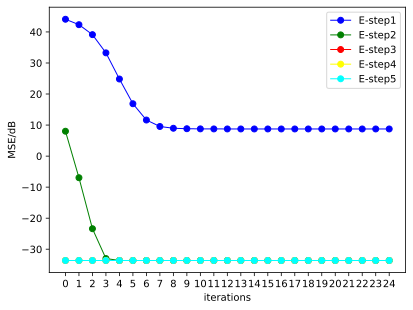

In [19]:
fig, ax = plt.subplots(1, 1)#制作图
plt.plot(dBEM[:,0], "-o", color="blue", linewidth=1.0,label = 'E-step1')
plt.plot(dBEM[:,1], "-o", color="green", linewidth=1.0,label = 'E-step2')
plt.plot(dBEM[:,2], "-o", color="red", linewidth=1.0,label = 'E-step3')
plt.plot(dBEM[:,3], "-o", color="yellow", linewidth=1.0,label = 'E-step4')
plt.plot(dBEM[:,4], "-o", color="cyan", linewidth=1.0,label = 'E-step5')

plt.xticks(range(0,k_max))
plt.legend(loc="upper right") 
plt.ylabel('MSE/dB')
plt.xlabel('iterations')
plt.savefig('hybrid_EM_NEW.svg')
plt.show()

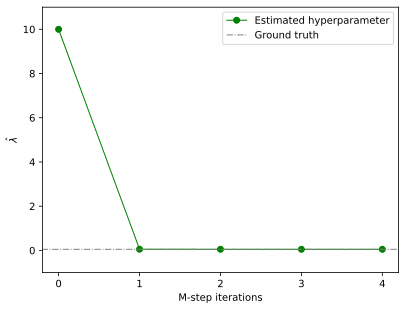

[[10.        ]
 [ 0.05577574]
 [ 0.05158407]
 [ 0.05158405]
 [ 0.05158405]
 [ 0.05158405]]


In [20]:
lambs_all[1:]=lambs

fig, ax = plt.subplots(1, 1)#制作图
plt.plot(lambs_all[0:5],"-o",color="green",linewidth=1.0,label = "Estimated hyperparameter")
plt.hlines(y = 0.05, xmin = -1, xmax = 5, color="grey", linestyles="dashdot", linewidth=1.0,label = "Ground truth")

plt.legend(loc="upper right") 

plt.ylim(-1,11)
plt.xlim(-0.2,4.2)

plt.xticks(range(0,5))
plt.ylabel('$\hat{\lambda}$')
plt.xlabel('M-step iterations')
plt.savefig('hybrid_EM_lambda.svg')
plt.show()

print(lambs_all)

In [21]:
lamb = lambs[-1]
print(lamb)


[0.05158405]


In [22]:
Mse0,x0,v0 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
dB0 = 10*np.log10(Mse0)

In [23]:

lamb = calambda(Nt,x0)

In [24]:
lamb

array([0.04442318])

In [25]:
Mse1,x1,v1 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
dB1 = 10*np.log10(Mse1)
lamb = calambda(Nt,x1)

print(lamb)


[0.05425976]


In [26]:

Mse2,x2,v2 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
dB2 = 10*np.log10(Mse2)
lamb = calambda(Nt,x2)

print(lamb)


[0.04849551]


In [27]:

Mse3,x3,v3 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
dB3 = 10*np.log10(Mse3)
lamb = calambda(Nt,x3)

print(lamb)


[0.05496301]


In [28]:

Mse4,x4,v4 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
dB4 = 10*np.log10(Mse4)
lamb = calambda(Nt,x4)

print(lamb)


[0.04607201]


In [29]:

Mse5,x5,v5 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
dB5 = 10*np.log10(Mse5)
lamb = calambda(Nt,x5)

print(lamb)


[0.05005081]


In [30]:
lamb

array([0.05005081])

In [31]:
SE5 = hybride_SE(Nr,Nt,k_max,wvar,lamb)


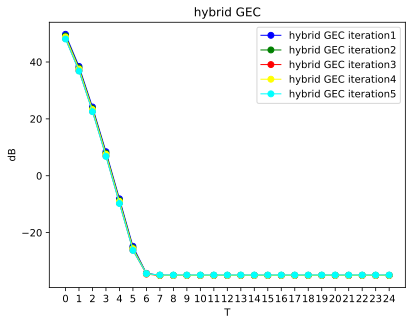

In [32]:
plt.plot(dB1, "-o", color="blue", linewidth=1.0,label = 'hybrid GEC iteration1')
plt.plot(dB2, "-o", color="green", linewidth=1.0,label = 'hybrid GEC iteration2')
plt.plot(dB3, "-o", color="red", linewidth=1.0,label = 'hybrid GEC iteration3')
plt.plot(dB4, "-o", color="yellow", linewidth=1.0,label = 'hybrid GEC iteration4')
plt.plot(dB5, "-o", color="cyan", linewidth=1.0,label = 'hybrid GEC iteration5')

plt.xticks(range(0,k_max))
plt.legend(loc="upper right") 
plt.title('hybrid GEC')
plt.ylabel('dB')
plt.xlabel('T')

plt.show()

In [35]:
Mse01,x01,v01 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB1 = 10*np.log10(Mse01)
Mse02,x02,v02 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB2 = 10*np.log10(Mse02)
Mse03,x03,v03 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB3 = 10*np.log10(Mse03)
Mse04,x04,v04 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB4 = 10*np.log10(Mse04)
Mse05,x05,v05 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB5 = 10*np.log10(Mse05)
Mse06,x06,v06 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB6 = 10*np.log10(Mse06)
Mse07,x07,v07 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB7 = 10*np.log10(Mse07)
Mse08,x08,v08 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB8 = 10*np.log10(Mse08)
Mse09,x09,v09 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB9 = 10*np.log10(Mse09)
Mse10,x10,v10 = hybrid_GEC_iter(Nr,Nt,wvar,k_max,T,lamb,dampFac,s)
hydB10 = 10*np.log10(Mse10)

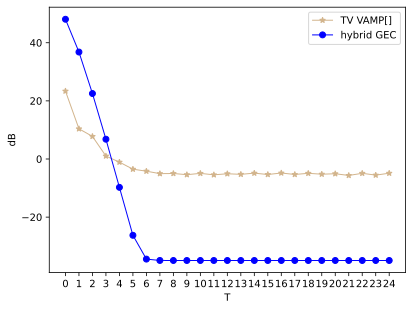

In [36]:
fig, ax = plt.subplots(1, 1)#制作图
#绘制主图
# plt.plot(TV_Mse1, "-*", color="tan", linewidth=1.0,label = 'TV VAMP[]')
plt.plot(dB5, "-o", color="blue", linewidth=1.0,label = 'hybrid GEC')

plt.xticks(range(0,k_max))
plt.legend(loc="upper right") 
plt.ylabel('dB')
plt.xlabel('T')

plt.show()

In [37]:
def reconstruct_dB(dBEM):
    reconMSE = np.zeros((k_max*4))
    reconMSE[0:25] = dBEM[:,0]
    reconMSE[25:50] = dBEM[:,1]
    reconMSE[50:75] = dBEM[:,2]
    reconMSE[75:100] = dBEM[:,3]
    return reconMSE

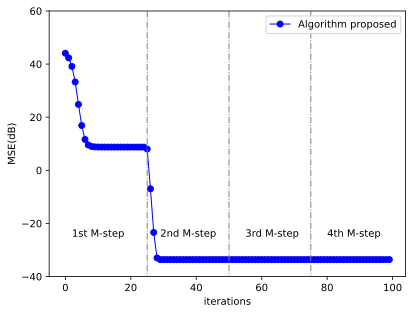

In [38]:
reMSE = reconstruct_dB(dBEM)
# reMSE = np.zeros((k_max*4))
# reMSE[0:25] = dBEM[:,0]
# reMSE[25:50] = dBEM[:,1]
# reMSE[50:75] = dBEM[:,2]
# reMSE[75:100] = dBEM[:,3]

fig, ax = plt.subplots(1, 1)#制作图
# plt.plot(dBEM[:,0], "-o", color="blue", linewidth=1.0,label = 'E-step1')
# plt.plot(dBEM[:,1], "-o", color="green", linewidth=1.0,label = 'E-step2')
# plt.plot(dBEM[:,2], "-o", color="red", linewidth=1.0,label = 'E-step3')
# plt.plot(dBEM[:,3], "-o", color="yellow", linewidth=1.0,label = 'E-step4')
# plt.plot(dBEM[:,4], "-o", color="cyan", linewidth=1.0,label = 'E-step5')

plt.plot(reMSE, "-o", color="blue", linewidth=1.0,label = 'Algorithm proposed')
plt.vlines(x = 25, ymin = -50, ymax = 60, color="gray", linestyles="dashdot", linewidth=1.0)
plt.vlines(x = 50, ymin = -50, ymax = 60, color="gray", linestyles="dashdot", linewidth=1.0)
plt.vlines(x = 75, ymin = -50, ymax = 60, color="gray", linestyles="dashdot", linewidth=1.0)

plt.ylim(-40,60)
plt.text(2,-25,"1st M-step")
plt.text(29,-25,"2nd M-step")
plt.text(55,-25,"3rd M-step")
plt.text(80,-25,"4th M-step")

#plt.xticks(range(0,k_max*3))
plt.legend(loc="upper right") 
#plt.title('our algorithm')
plt.ylabel('MSE(dB)')
plt.xlabel('iterations')
plt.savefig('hybrid_iter.svg')
plt.show()

In [39]:
k_max_100 = 100
MseHu,xHu,vHu = hybrid_GEC_iter(Nr,Nt,wvar,k_max_100,T,lamb,dampFac,s)
dBHu = 10*np.log10(MseHu)
# TV_Mse100 = TVVAMP(Nr,Nt,wvar,k_max_100,T,lamb_TVVAMP,dampFac)

In [95]:
# TVA_100 = TVAMP2(Nr,Nt,wvar,k_max_100,T,lamb_TVVAMP,dampFac15)

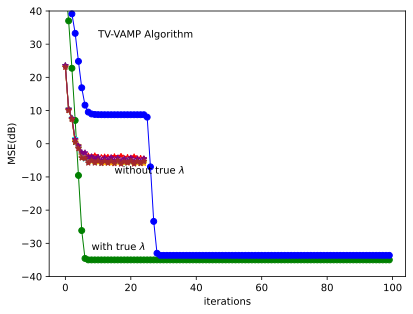

In [87]:
fig, ax = plt.subplots(1, 1)#制作图
plt.plot(dBHu, "-o", color="green", linewidth=1.0,label = '')
plt.plot(reMSE, "-o", color="blue", linewidth=1.0,label = 'Algorithm proposed')

plt.plot(TV_Mse1, "-*", color="tan", linewidth=1.0,label = '')
plt.plot(TV_Mse2, "-*", color="green", linewidth=1.0,label = '')
plt.plot(TV_Mse3, "-*", color="red", linewidth=1.0,label = '')
plt.plot(TV_Mse4, "-*", color="yellow", linewidth=1.0,label = '')
plt.plot(TV_Mse5, "-*", color="cyan", linewidth=1.0,label = '')
plt.plot(TV_Mse6, "-*", color="orange", linewidth=1.0,label = '')
plt.plot(TV_Mse7, "-*", color="pink", linewidth=1.0,label = '')
plt.plot(TV_Mse8, "-*", color="grey", linewidth=1.0,label = '')
plt.plot(TV_Mse9, "-*", color="purple", linewidth=1.0,label = '')
plt.plot(TV_Mse10, "-*", color="brown", linewidth=1.0,label = '')

plt.text(15,-9,"without true $\lambda$")
plt.text(8,-32,"with true $\lambda$")
plt.text(10,32,"TV-VAMP Algorithm")

plt.ylabel('MSE(dB)')
plt.xlabel('iterations')
plt.ylim(-40,40)
plt.savefig('contrast3.svg')
plt.show()

In [42]:
def hybride_SE_ALTER(Nr,Nt,k_max,wvar,lamb):
    ini = 1000000
    semse = np.zeros(k_max) 
    lamA = lam(Nr,Nt)
    v1_p = ini
    va_p = ini
    vb_p = ini
    vc_p = ini
    Vz = ini
    v1_m = ini
    vc_m = ini
    for t in range(0,k_max):

        Vz_new = 1/(1/v1_p + 1/wvar)
        Vz = damping(Vz,Vz_new,0.01)
        
        v1_m_new = 1/(1/Vz - 1/v1_p)
        v1_m = damping(v1_m,v1_m_new,0.03)
        
        Vx_m = np.sum(1/(lamA/v1_m + 1/vc_p))/Nt
        vc_m = 1/(1/Vx_m - 1/vc_p)
        va_m = 1/(1/vb_p + 1/vc_m)
        vb_m = 1/(1/va_p + 1/vc_m)
        va_p = vb_m + 1/(lamb**2)
        vb_p = va_m + 1/(lamb**2)
        vc_p = 1/(1/va_p + 1/vb_p)
        semse[t] = 1/(1/vc_p + 1/vc_m)
        
        Vz_p = np.sum(lamA/(lamA/v1_m+1/vc_p))/Nr
        v1_p = 1/(1/Vz_p - 1/v1_m)
        
    #print(semse)
    return 10*np.log10(semse)

In [43]:
SE_ALTER = hybride_SE_ALTER(Nr,Nt,k_max,wvar,lamb)

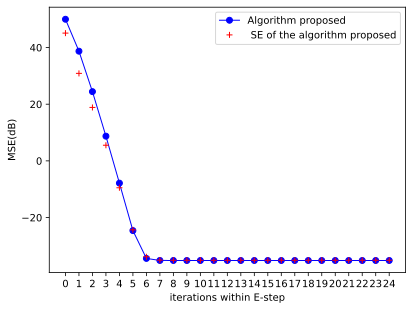

In [44]:
fig, ax = plt.subplots(1, 1)#制作图
plt.plot(hydB5, "-o", color="blue", linewidth=1.0,label = 'Algorithm proposed')
plt.plot(SE_ALTER, "+", color="red", linewidth=1.0,label = ' SE of the algorithm proposed')

plt.ylabel('MSE(dB)')
plt.xlabel('iterations within E-step')


plt.xticks(range(0,k_max))
plt.legend(loc="upper right") 
plt.savefig('hybrid_SE_ALTER.svg')
plt.show()

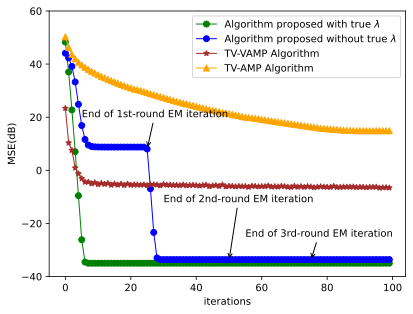

In [96]:
fig, ax = plt.subplots(1, 1)#制作图
plt.plot(dBHu, "-o", color="green", linewidth=1.0,label = 'Algorithm proposed with true $\lambda$')
plt.plot(reMSE, "-o", color="blue", linewidth=1.0,label = 'Algorithm proposed without true $\lambda$')

# plt.plot(TV_Mse1, "-*", color="tan", linewidth=1.0,label = '')
# plt.plot(TV_Mse2, "-*", color="green", linewidth=1.0,label = '')
# plt.plot(TV_Mse3, "-*", color="red", linewidth=1.0,label = '')
# plt.plot(TV_Mse4, "-*", color="yellow", linewidth=1.0,label = '')
# plt.plot(TV_Mse5, "-*", color="cyan", linewidth=1.0,label = '')
# plt.plot(TV_Mse6, "-*", color="orange", linewidth=1.0,label = '')
# plt.plot(TV_Mse7, "-*", color="pink", linewidth=1.0,label = '')
# plt.plot(TV_Mse8, "-*", color="grey", linewidth=1.0,label = '')
# plt.plot(TV_Mse9, "-*", color="purple", linewidth=1.0,label = '')
plt.plot(TV_Mse100, "-*", color="brown", linewidth=1.0,label = 'TV-VAMP Algorithm')
plt.plot(TVA_100, "-^", color="orange", linewidth=1.0,label = 'TV-AMP Algorithm')

# plt.text(15,-9,"without true $\lambda$")
# plt.text(8,-32,"with true $\lambda$")
# plt.text(8,28,"TV-VAMP Algorithm")
# plt.text(30,15,"End of 1st-round EM iteration")
plt.annotate("End of 1st-round EM iteration", xy=(25,8), xytext=(5, 20),
             arrowprops=dict(arrowstyle='->'))
plt.annotate("End of 2nd-round EM iteration", xy=(50,-34), xytext=(30, -12),
             arrowprops=dict(arrowstyle='->'))
plt.annotate("End of 3rd-round EM iteration", xy=(75,-34), xytext=(55, -25),
             arrowprops=dict(arrowstyle='->'))

plt.ylabel('MSE(dB)')
plt.xlabel('iterations')
plt.legend(loc="upper right")
plt.ylim(-40,60)
plt.savefig('contrast4.svg')
plt.show()

In [46]:
lamb_ini = 10

In [47]:
hy_snr = np.zeros((k_max_100,8))
for i in range(8):
    snr_i=(i+1)*5
    wvar_snr =10**(-snr_i/10)
    Mse_snr,lambs_snr = hybrid_EM(Nr,Nt,wvar_snr,k_max,Ti,lamb_ini,dampFac,s,mode = 'lim')
    dBEM_snr = 10*np.log10(Mse_snr)
    hy_snr[:,i] = reconstruct_dB(dBEM_snr)

In [48]:
TV_snr = np.zeros((k_max_100,8))
for i in range(8):
    snr_i=(i+1)*5
    wvar_snr =10**(-snr_i/10)
    # TV_snr[:,i] = TVVAMP(Nr,Nt,wvar_snr,k_max_100,T,lamb_TVVAMP,dampFac)


In [97]:

TVA_snr = np.zeros((k_max_100,8))
for i in range(8):
    snr_i=(i+1)*5
    wvar_snr =10**(-snr_i/10)
    # TVA_snr[:,i] = TVAMP2(Nr,Nt,wvar_snr,k_max_100,T,lamb_TVVAMP,dampFac15)


In [50]:
wvar_snr0 = 10**(-5/10)
wvar_snr1 = 10**(-10/10)
wvar_snr2 = 10**(-15/10)
wvar_snr3 = 10**(-20/10)
wvar_snr4 = 10**(-25/10)
wvar_snr5 = 10**(-30/10)
wvar_snr6 = 10**(-35/10)
wvar_snr7 = 10**(-40/10)
snr_str = np.zeros(8)
for i in range(8):
    snr_str[i]=(i+1)*5

In [105]:
wvar_str = snr_str*(-1)

In [55]:
hy_r_snr = np.zeros((k_max_100,8))
for i in range(8):
    snr_i=(i+1)*5
    wvar_snr =10**(-snr_i/10)
    MseH,xH,vH = hybrid_GEC_iter(Nr,Nt,wvar_snr,k_max_100,T,lamb_TVVAMP,dampFac,s)
    hy_r_snr[:,i] = 10*np.log10(MseH)

In [56]:
SE_snr = np.zeros((k_max_100,8))
for i in range(8):
    snr_i=(i+1)*5
    wvar_snr =10**(-snr_i/10)
    SE_snr[:,i] = hybride_SE_ALTER(Nr,Nt,k_max_100,wvar_snr,lamb_TVVAMP)

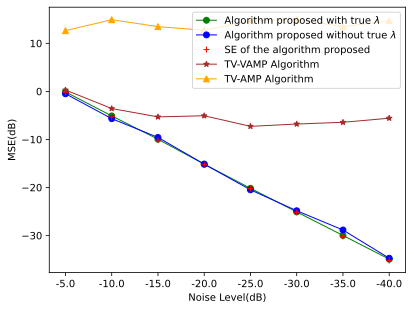

In [106]:
plt.plot(hy_r_snr[-1,:], "-o", color="green", linewidth=1.0,
         label = 'Algorithm proposed with true $\lambda$')
plt.plot(hy_snr[-1,:], "-o", color="blue", linewidth=1.0,
         label = 'Algorithm proposed without true $\lambda$')
plt.plot(SE_snr[-1,:], "+", color="red", linewidth=1.0,
         label = 'SE of the algorithm proposed')
plt.plot(TV_snr[-1,:], "-*", color="brown", linewidth=1.0,label = 'TV-VAMP Algorithm')
plt.plot(TVA_snr[-1,:], "-^", color="orange", linewidth=1.0,label = 'TV-AMP Algorithm')



plt.xticks(range(8),wvar_str)
plt.legend(loc="upper right") 
plt.ylabel('MSE(dB)')
plt.xlabel('Noise Level(dB)')
plt.savefig('snr_con.svg')
plt.show()

In [58]:
Nr_str = [210,300,400,500,600,700,800,900,1000]
k_len = len(Nr_str)
k_str = np.zeros(k_len)
for i in range(k_len):
    k_str[i] = Nr_str[i]/Nt

In [59]:
TV_k = np.zeros((k_max_100,k_len))
for i in range(k_len):
    # TV_k[:,i] = TVVAMP(Nr_str[i],Nt,wvar,k_max_100,T,lamb_TVVAMP,dampFac)

In [62]:
TVA_k = np.zeros((k_max_100,k_len))

In [72]:
hy_k = np.zeros((k_max_100,k_len))
for i in range(k_len):
    Mse_k,lambs_k = hybrid_EM(Nr_str[i],Nt,wvar,k_max,Ti,lamb_ini,dampFac,s,mode = 'lim')
    dBEM_k = 10*np.log10(Mse_k)
    hy_k[:,i] = reconstruct_dB(dBEM_k)

In [73]:
hy_k_1 = np.zeros((k_max_100,k_len))
for i in range(k_len):
    Mse_k_1,lambs_k_1 = hybrid_EM(Nr_str[i],Nt,wvar,k_max,Ti,lamb_ini,dampFac,s,mode = 'lim')
    dBEM_k_1 = 10*np.log10(Mse_k_1)
    hy_k_1[:,i] = reconstruct_dB(dBEM_k_1)

In [74]:
Mse_k_1,lambs_k_1 = hybrid_EM(Nr_str[3],Nt,wvar,k_max,Ti,lamb_ini,dampFac,s,mode = 'lim')
dBEM_k_1 = 10*np.log10(Mse_k_1)
hy_k_1[:,3] = reconstruct_dB(dBEM_k_1)

In [75]:
Mse_k,lambs_k = hybrid_EM(Nr_str[7],Nt,wvar,k_max,Ti,lamb_ini,dampFac,s,mode = 'lim')
dBEM_k = 10*np.log10(Mse_k)
hy_k[:,7] = reconstruct_dB(dBEM_k)

In [76]:
Mse_k,lambs_k = hybrid_EM(Nr_str[8],Nt,wvar,k_max,Ti,lamb_ini,dampFac,s,mode = 'lim')
dBEM_k = 10*np.log10(Mse_k)
hy_k[:,8] = reconstruct_dB(dBEM_k)

In [77]:
hy_r_k = np.zeros((k_max_100,k_len))
for i in range(k_len):
    MseHu,xHu,vHu = hybrid_GEC_iter(Nr_str[i],Nt,wvar,k_max_100,T,lamb_TVVAMP,dampFac,s)
    hy_r_k[:,i] = 10*np.log10(MseHu)

In [78]:
SE_k = np.zeros((k_max_100,k_len))
for i in range(k_len):
    SE_k[:,i] = hybride_SE_ALTER(Nr_str[i],Nt,k_max_100,wvar,lamb_TVVAMP)

In [79]:
k_str[0] = 1
k_xt = k_str
k_xt[0] = 1.05

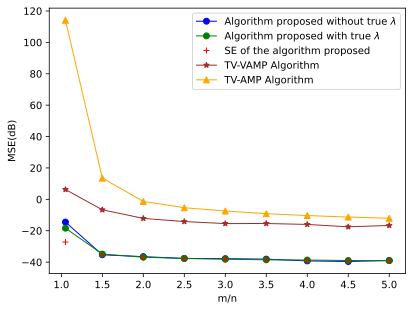

In [100]:
plt.plot(k_str,hy_k_1[-1,:], "-o", color="blue", linewidth=1.0,
         label = 'Algorithm proposed without true $\lambda$')
plt.plot(k_str,hy_r_k[-1,:], "-o", color="green", linewidth=1.0,
         label = 'Algorithm proposed with true $\lambda$')
plt.plot(k_str,SE_k[-1,:], "+", color="red", linewidth=1.0,
         label = 'SE of the algorithm proposed')
plt.plot(k_str,TV_k[-1,:], "-*", color="brown", linewidth=1.0,label = 'TV-VAMP Algorithm')
plt.plot(k_str,TVA_k[-1,:], "-^", color="orange", linewidth=1.0,label = 'TV-AMP Algorithm')
#plt.xticks(range(k_len),k_str)
plt.legend(loc="upper right") 
plt.ylabel('MSE(dB)')
plt.xlabel('m/n')
plt.savefig('MN_con.svg')
plt.show()

In [101]:
#k_str

In [103]:
xgene(Nt)

array([[   0.63082549],
       [  -3.74556565],
       [   3.89892699],
       [  18.13354287],
       [ -10.37761123],
       [ -14.3637693 ],
       [  -1.29846439],
       [ -19.85254828],
       [  52.43259523],
       [  18.03057666],
       [  37.97411104],
       [ -12.47570759],
       [ -17.3405883 ],
       [ -14.72565017],
       [ -18.78120351],
       [ -40.49896386],
       [ -54.69087089],
       [ -71.59843197],
       [ -65.52078707],
       [ -99.00271233],
       [ -95.98444547],
       [ -97.90654706],
       [ -86.2650533 ],
       [-143.7128634 ],
       [-149.11595196],
       [-144.59980597],
       [-132.33747601],
       [-128.53786266],
       [-145.03786231],
       [ -89.26711696],
       [ -87.61919698],
       [ -90.13232848],
       [ -81.31801657],
       [ -64.08376773],
       [ -30.64062476],
       [ -88.2193734 ],
       [ -69.14531659],
       [ -44.57300938],
       [ -49.69208765],
       [ -66.11604421],
       [-109.43649803],
       [-126.314